In [ ]:
#!unzip "drive/MyDrive/Chest/archive.zip" -d "drive/MyDrive/Chest/"

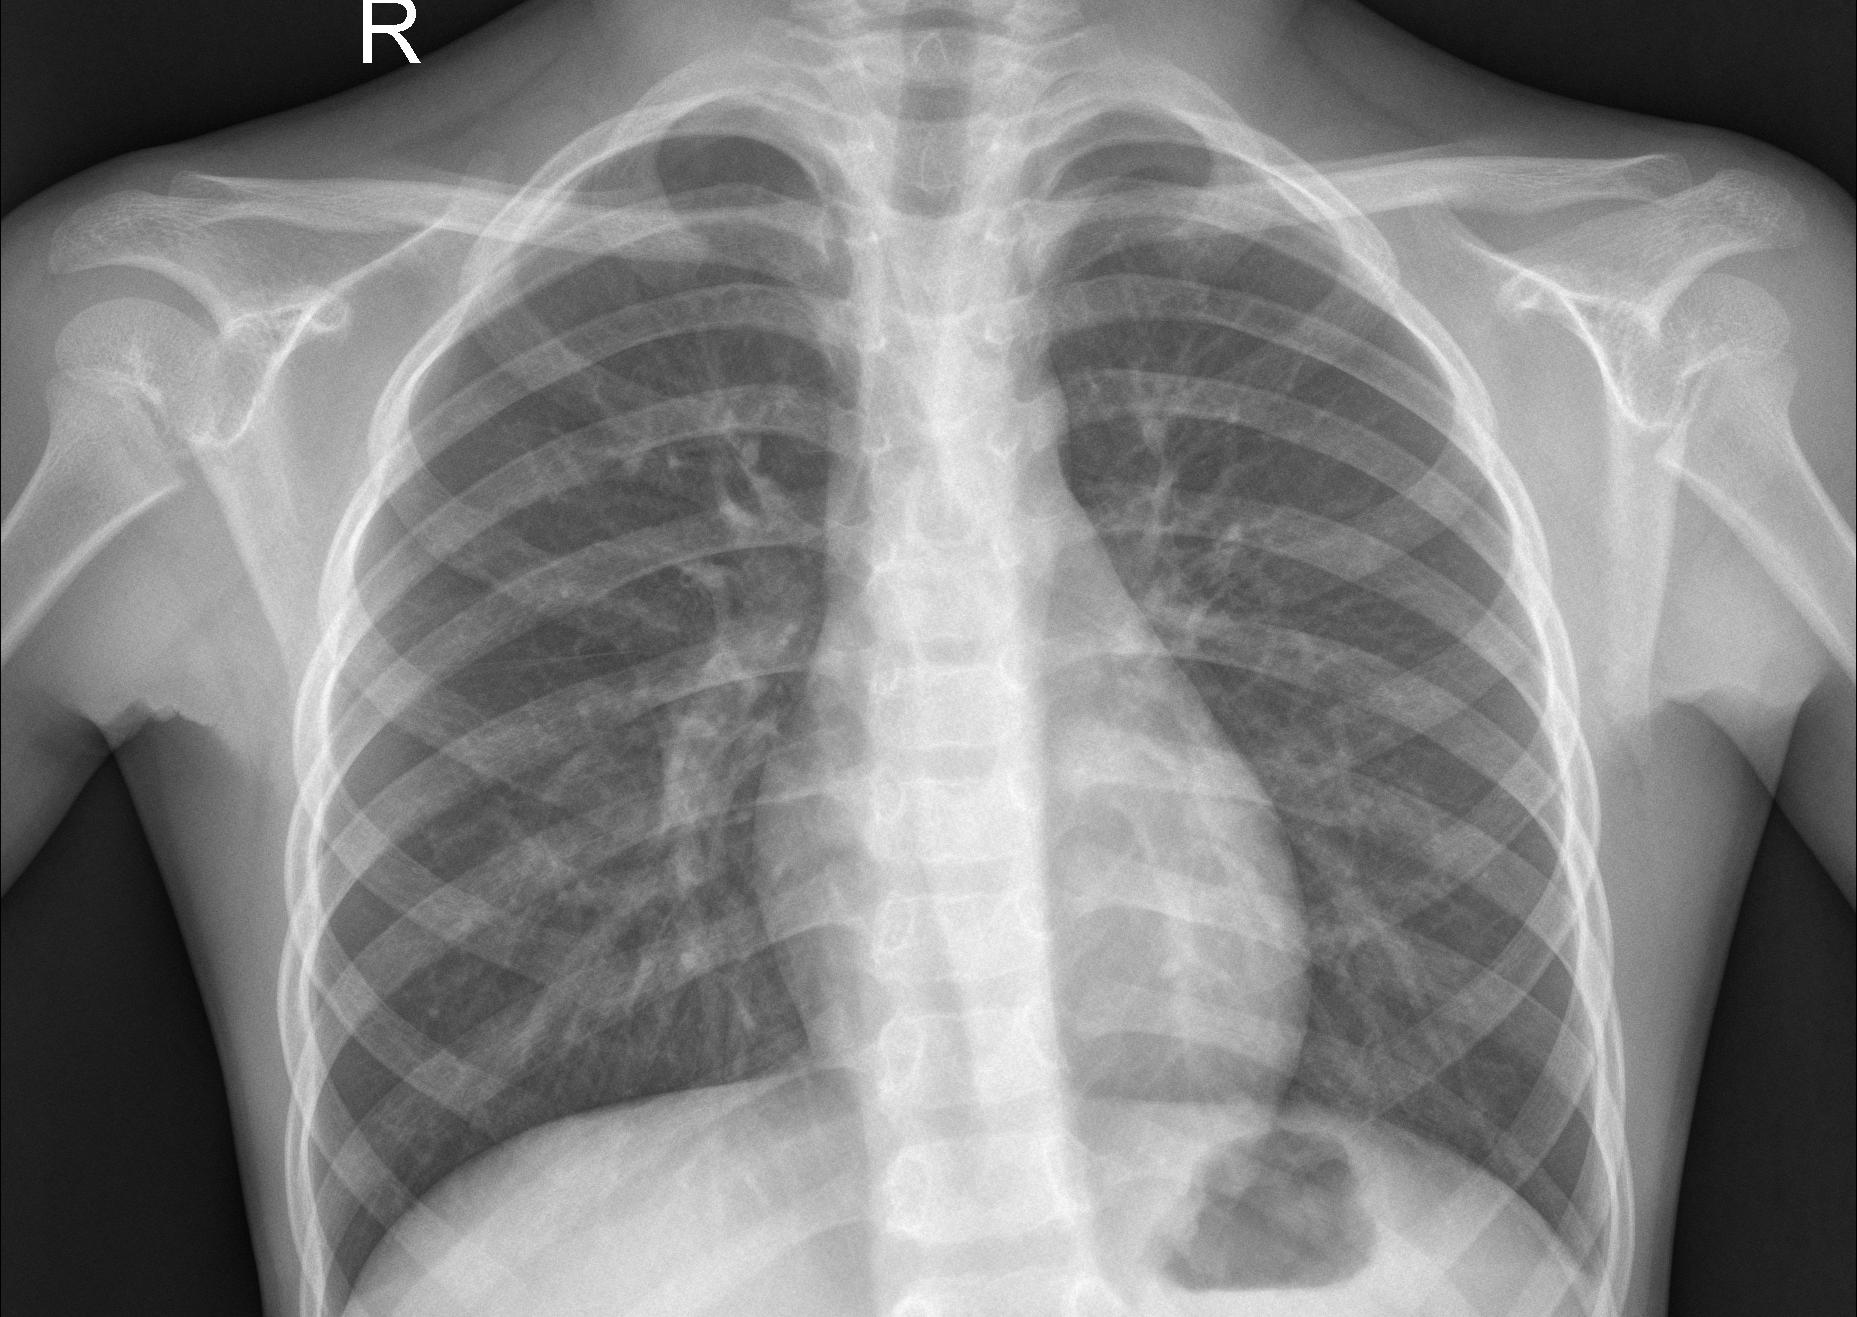

In [ ]:
from IPython.display import display, Image
Image("/content/drive/MyDrive/Chest/chest_xray/test/NORMAL/IM-0001-0001.jpeg")

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

TF version: 2.5.0
Hub version: 0.12.0


In [ ]:
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available (YESS!!!!)


In [ ]:
path_dirs ={ 'train':"/content/drive/MyDrive/Chest/chest_xray/train/",
        'val':"/content/drive/MyDrive/Chest/chest_xray/val/",
        'test':"/content/drive/MyDrive/Chest/chest_xray/test/"}

In [ ]:
def create_data_frame(class_name):
  normal = [(x,'Normal') for x in os.listdir(path_dirs[class_name]+"NORMAL/")]
  pneumonia = [(x,'Pneumonia') for x in os.listdir(path_dirs[class_name]+"PNEUMONIA/")]
  data=normal+pneumonia
  labels = pd.DataFrame(data,columns=['id','condition'])
  return labels



In [12]:
train_df = create_data_frame('train')
train_df

,id,condition
0,IM-0523-0001.jpeg,Normal
1,IM-0513-0001.jpeg,Normal
2,IM-0511-0001.jpeg,Normal
3,IM-0520-0001.jpeg,Normal
4,IM-0517-0001-0001.jpeg,Normal
...,...,...
5211,person141_virus_287.jpeg,Pneumonia
5212,person1378_bacteria_3513.jpeg,Pneumonia
5213,person1368_virus_2353.jpeg,Pneumonia
5214,person1372_bacteria_3499.jpeg,Pneumonia


In [13]:
val_df = create_data_frame('val')
val_df

,id,condition
0,NORMAL2-IM-1437-0001.jpeg,Normal
1,NORMAL2-IM-1431-0001.jpeg,Normal
2,NORMAL2-IM-1440-0001.jpeg,Normal
3,NORMAL2-IM-1442-0001.jpeg,Normal
4,NORMAL2-IM-1436-0001.jpeg,Normal
5,NORMAL2-IM-1427-0001.jpeg,Normal
6,NORMAL2-IM-1430-0001.jpeg,Normal
7,NORMAL2-IM-1438-0001.jpeg,Normal
8,person1946_bacteria_4874.jpeg,Pneumonia
9,person1954_bacteria_4886.jpeg,Pneumonia


In [14]:
test_df = create_data_frame('test')
test_df

,id,condition
0,IM-0016-0001.jpeg,Normal
1,IM-0011-0001-0001.jpeg,Normal
2,IM-0003-0001.jpeg,Normal
3,IM-0001-0001.jpeg,Normal
4,IM-0006-0001.jpeg,Normal
...,...,...
619,person21_virus_53.jpeg,Pneumonia
620,person1655_virus_2861.jpeg,Pneumonia
621,person71_virus_132.jpeg,Pneumonia
622,person1651_virus_2855.jpeg,Pneumonia


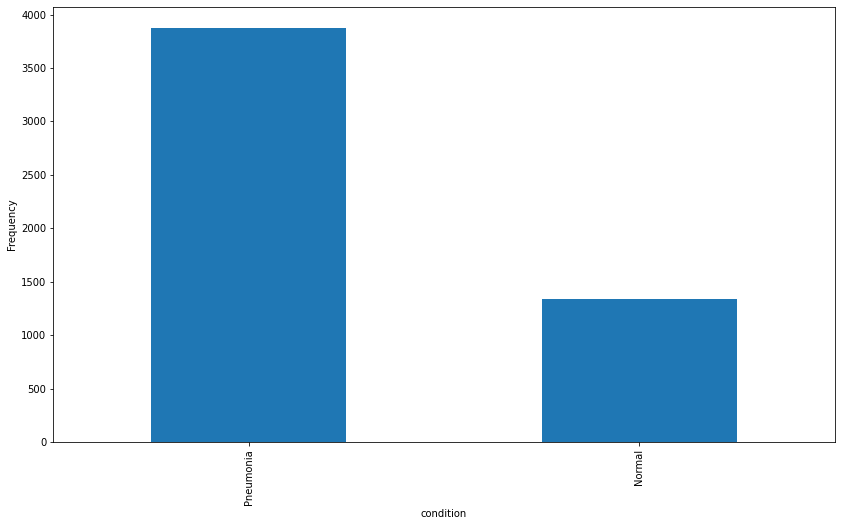

In [18]:
ax = train_df['condition'].value_counts().plot(kind='bar',
                                    figsize=(14,8))
ax.set_xlabel("condition")
ax.set_ylabel("Frequency")
plt.show()

In [19]:
def get_filenames(class_name):
  normal = [path_dirs[class_name]+"NORMAL/"+x for x in os.listdir(path_dirs[class_name]+"NORMAL/")]
  pneumonia = [path_dirs[class_name]+"PNEUMONIA/"+x for x in os.listdir(path_dirs[class_name]+"PNEUMONIA/")]
  filenames=normal+pneumonia
  return filenames

In [25]:
train_filenames = get_filenames('train')
len(train_filenames)

5216

In [26]:
val_filenames = get_filenames('val')
len(val_filenames)

16

In [30]:
test_filenames = get_filenames('test')
len(test_filenames)

624

In [53]:
classes = ['Normal','Pneumonia']
def boolean_values(df):
  boolean_labels = [label == np.array(classes) for label in df['condition']]
  return boolean_labels

In [54]:
X_train = train_filenames
y_train = boolean_values(train_df)
len(X_train),len(y_train)

(5216, 5216)

In [47]:
X_val = val_filenames
y_val = boolean_values(val_df)
len(X_val),len(y_val)

(16, 16)

In [64]:
X_test = test_filenames
y_test = boolean_values(test_df)
len(X_test),len(y_test)

(624, 624)

In [48]:
IMG_SIZE = 224
def process_image(image_path):
  """
  Takes an image file path and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired size (224, 244)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [49]:

# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [50]:
# Define the batch size, 32 is a good default
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels
    
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [51]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [52]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)))

In [55]:

# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(classes)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [56]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, 
                          activation="sigmoid") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(), # Our model wants to reduce this (how wrong its guesses are)
      optimizer=tf.keras.optimizers.Adam(), # A friend telling our model how to improve its guesses
      metrics=["accuracy"] # We'd like this to go up
  )

  # Build the model
  model.build(INPUT_SHAPE) # Let the model know what kind of inputs it'll be getting
  
  return model

In [57]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 2)                 2004      
Total params: 5,434,717
Trainable params: 2,004
Non-trainable params: 5,432,713
_________________________________________________________________


In [58]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [59]:
import os
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/MyDrive/Data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [60]:
# Create early stopping (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

In [61]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [62]:
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])
  
  return model

In [63]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
163/163 [==============================] - 1189s 7s/step - loss: 0.1461 - accuracy: 0.9429 - val_loss: 0.7808 - val_accuracy: 0.7500
Epoch 2/100
163/163 [==============================] - 61s 373ms/step - loss: 0.0882 - accuracy: 0.9663 - val_loss: 0.4432 - val_accuracy: 0.7500
Epoch 3/100
163/163 [==============================] - 58s 357ms/step - loss: 0.0758 - accuracy: 0.9699 - val_loss: 0.5303 - val_accuracy: 0.7500
Epoch 4/100
163/163 [==============================] - 59s 360ms/step - loss: 0.0719 - accuracy: 0.9718 - val_loss: 0.4683 - val_accuracy: 0.7500


In [66]:
test_data=create_data_batches(X_test, y_test, test_data=True)

Creating test data batches...


In [67]:
predictions = model.predict(test_data, verbose=1) # verbose shows us how long there is to go
predictions

20/20 [==============================] - 110s 5s/step


array([[0.93783045, 0.715645  ],
       [0.7598951 , 0.818891  ],
       [0.9913408 , 0.5449751 ],
       ...,
       [0.03775293, 0.9969971 ],
       [0.01525813, 0.99992883],
       [0.01454879, 0.9995764 ]], dtype=float32)

In [68]:
predictions.shape

(624, 2)

In [75]:
len(predictions)

624

In [69]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {classes[np.argmax(predictions[0])]}") # the predicted label

[0.93783045 0.715645  ]
Max value (probability of prediction): 0.9378304481506348
Sum: 1.6534755229949951
Max index: 0
Predicted label: Normal


In [78]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return classes[np.argmax(prediction_probabilities)]

pred_label=[]
for i in range(len(predictions)):
  pred_label.append(get_pred_label(predictions[i]))
pred_label

['Normal',
 'Pneumonia',
 'Normal',
 'Pneumonia',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Pneumonia',
 'Normal',
 'Normal',
 'Normal',
 'Pneumonia',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Pneumonia',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Pneumonia',
 'Pneumonia',
 'Pneumonia',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Pneumonia',
 'Normal',
 'Pneumonia',
 'Normal',
 'Normal',
 'Pneumonia',
 'Normal',
 'Normal',
 'Pneumonia',
 'Pneumonia',
 'Normal',
 'Pneumonia',
 'Normal',
 'Pneumonia',
 'Pneumonia',
 'Normal',
 'Pneumonia',
 'Normal',
 'Pneumonia',
 'Pneumonia',
 'Normal',
 'Pneumonia',
 'Normal',
 'Normal',
 'Pneumonia',
 'Pneumonia',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Pneumonia',
 'Pneumonia',
 'Normal',
 'Normal',
 'Pneumonia',
 'Pneumonia',
 'Normal',
 'Normal',
 'Normal',
 'Pneumonia',
 'Pneumonia',
 'Pneumonia',
 'Pneumonia',
 'Normal

In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(test_df['condition'],pred_label)

0.7948717948717948